<a href="https://colab.research.google.com/github/shivag/cs145/blob/main/Spotify's_SQL_example_CS145.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 145 -- How to build a Spotify-like data app with SQL

(Audience: BS and MS level students in cs145.stanford.edu. Intro to Big Data)

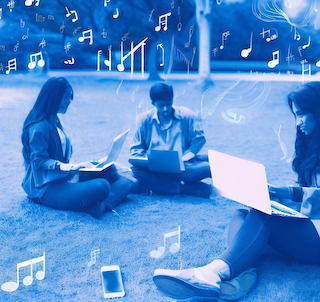

# Learning Goals for SQL
Explore a world of music through the power of SQL. Here's what you'll do with this basic database to power an app for Spotify-like use cases:

1. Find your groove: Discover songs by your favorite artists and genres. Use SQL to search for tracks that match your musical taste and create playlists.

2. Track your journey: Dig into your listening history and analyze your music habits. SQL queries help you uncover the songs that have been your loyal companions along the way.

3. Get personalized recommendations: Analyze your listening habits, compare them to others, and unlock a treasure trove of new music.

4. Rate the hits: Become a music critic and explore average song ratings. You can compute and delve into the average ratings of songs across different genres.

Specifically, here are the Steps we'll run through in this notebook.
1. **Basic SQL**: Create the DB's schema and load data. Perform basic SQL queries using ORDER BY, GROUP BY, LIMIT, and JOINS. Handle NULL values and use set operators like IN, EXISTS, UNION, and INTERSECT. (Example 1)

2. **Modular SQL**: Utilize Common Table Expressions (CTEs) and nested queries to compute personalized song recommendations. (Example 2)

3. **Intermediate SQL**: Calculate average ratings for songs.
Utilize WINDOW functions and GROUP BY clauses to summarize song ratings. (Example 3)

4. **Deconstructing SQL queries**: Analyze and break down SQL queries that are similar. (Exercise 1)

---


[Optional]

5. Data Privacy Considerations: Explore techniques to anonymize and protect sensitive data
6. Key-Value Store Integration: Store a song into a key-value store like Google's BigTable

By the end of this section, you will be able to apply SQL techniques to set up and query a Spotify database, compute recommendations, analyze song ratings, deconstruct complex SQL queries, understand data privacy considerations, and work with key-value stores. These skills will enhance your understanding of database management and enable you to work on real-world examples.

# Example 1: Set up Spotify DB (Basic SQL)


## Setup "schema" and load data

In [ ]:
!pip install pysqlite3
from pysqlite3 import dbapi2 as sqlite3
print(sqlite3.sqlite_version)
import pandas as pd
from IPython.display import display, HTML
dbname = "music_streaming3.db"

def printSqlResults(cursor, tblName):
  try:
    df = pd.DataFrame(cursor.fetchall(), columns=[i[0] for i in cursor.description])
    display(HTML("<b><font color=Green> " + tblName + "</font></b>" + df.to_html(index=False)))
  except:
    pass

def runSqlCursor(cursor, caption, query):
  cursor.execute(query)
  printSqlResults(cursor, caption)

def runSql(caption, query):
  conn = sqlite3.connect(dbname)
  cursor = conn.cursor()
  cursor.execute(query)
  printSqlResults(cursor, caption)
  conn.close()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysqlite3: filename=pysqlite3-0.5.1-cp310-cp310-linux_x86_64.whl size=163744 sha256=674ab2ef6a00912c5d367df2993614edfee8e015c7d965b08737356a41e42243
  Stored in directory: /root/.cache/pip/wheels/ed/1d/da/4bb79a0c7885888c6be9e31dad7ebd3b47b023be60469fd74d
Successfully built pysqlite3
3.31.1


In [ ]:

# Connect to database (creates the file if it doesn't exist)
conn = sqlite3.connect(dbname)
cursor = conn.cursor()

# Create the Users table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Users (
    user_id INTEGER PRIMARY KEY,
    name VARCHAR(100) NOT NULL,
    email VARCHAR(100) NOT NULL UNIQUE
);
""")

# Create the Songs table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Songs (
    song_id INTEGER PRIMARY KEY,
    title VARCHAR(100) NOT NULL,
    artist VARCHAR(100) NOT NULL,
    genre VARCHAR(100)
);
""")

# Create the Listens table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Listens (
    listen_id INTEGER PRIMARY KEY,
    user_id INTEGER NOT NULL,
    song_id INTEGER NOT NULL,
    rating FLOAT,
    listen_time TIMESTAMP,
    FOREIGN KEY (user_id) REFERENCES Users(user_id),
    FOREIGN KEY (song_id) REFERENCES Songs(song_id)
);
""")

# Create the recommendations table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Recommendations (
    user_id INTEGER NOT NULL,
    song_id INTEGER NOT NULL,
    recommendation_id not NULL,
    recommendation_time TIMESTAMP,
    FOREIGN KEY (user_id) REFERENCES Users(user_id),
    FOREIGN KEY (song_id) REFERENCES Songs(song_id)
);
""")

# Commit changes and close the connection
conn.commit()
conn.close()

In [ ]:
# Connect to database again and insert sample data
conn = sqlite3.connect(dbname)
sqlite3.enable_callback_tracebacks(True)

cursor = conn.cursor()
cursor.execute("delete from Songs;")
cursor.execute("delete from Users;")
cursor.execute("delete from Listens;")
cursor.execute("delete from Recommendations;")

# Insert sample users
cursor.execute("""
INSERT INTO Users (user_id, name, email)
VALUES
    (1, 'Mickey', 'mickey@example.com'),
    (2, 'Minnie', 'minnie@example.com'),
    (3, 'Daffy', 'daffy@example.com'),
    (4, 'Pluto', 'pluto@example.com');
""")

# Insert sample songs from Taylor Swift, Ed Sheeran, Beatles
cursor.execute("""
INSERT INTO Songs (song_id, title, artist, genre)
VALUES
    (1, 'Evermore', 'Taylor Swift', 'Pop'),
    (2, 'Willow', 'Taylor Swift', 'Pop'),
    (3, 'Shape of You', 'Ed Sheeran', 'Rock'),
    (4, 'Photograph', 'Ed Sheeran', 'Rock'),
    (5, 'Shivers', 'Ed Sheeran', 'Rock'),
    (6, 'Yesterday', 'Beatles', 'Classic'),
    (7, 'Yellow Submarine', 'Beatles', 'Classic'),
    (8, 'Hey Jude', 'Beatles', 'Classic'),
    (9, 'Bad Blood', 'Taylor Swift', 'Rock'),
    (10, 'DJ Mix', 'DJ', NULL);
""")

# Insert sample listens
cursor.execute("""
INSERT INTO Listens (listen_id, user_id, song_id, rating)
VALUES
    (1, 1, 1, 4.5),
    (2, 1, 2, 4.2),
    (3, 1, 6, 3.9),
    (4, 2, 2, 4.7),
    (5, 2, 7, 4.6),
    (6, 2, 8, 3.9),
    (7, 3, 1, 2.9),
    (8, 3, 2, 4.9),
    (9, 3, 6, Null);
""")
# Commit changes and close the connection
conn.commit()
conn.close()

runSql('Users', "select * from Users;")
runSql('Songs', "select * from Songs;")
runSql('Listens', "select * from Listens;")

user_id,name,email
1,Mickey,mickey@example.com
2,Minnie,minnie@example.com
3,Daffy,daffy@example.com
4,Pluto,pluto@example.com


song_id,title,artist,genre
1,Evermore,Taylor Swift,Pop
2,Willow,Taylor Swift,Pop
3,Shape of You,Ed Sheeran,Rock
4,Photograph,Ed Sheeran,Rock
5,Shivers,Ed Sheeran,Rock
6,Yesterday,Beatles,Classic
7,Yellow Submarine,Beatles,Classic
8,Hey Jude,Beatles,Classic
9,Bad Blood,Taylor Swift,Rock
10,DJ Mix,DJ,None


listen_id,user_id,song_id,rating,listen_time
1,1,1,4.5,None
2,1,2,4.2,None
3,1,6,3.9,None
4,2,2,4.7,None
5,2,7,4.6,None
6,2,8,3.9,None
7,3,1,2.9,None
8,3,2,4.9,None
9,3,6,NaN,None


## Basic SQL queries (ORDER BY, GROUP BY, LIMIT, JOINS, LEFT JOINs)

In [ ]:
""" Goal: Learn basic forms of SELECT, FROM, WHERE, DISTINCT """

qry_classic_songs = """
-- Find the titles and artists of songs in the "Classic" genre.
SELECT Songs.title, Songs.artist
FROM Songs
WHERE Songs.genre = 'Classic';"""
runSql('Classic songs', qry_classic_songs)

qry_genres = """
-- List of unique genres in the Songs table
SELECT genre
FROM Songs;"""
runSql('All genres in the Songs table', qry_genres)

qry_distinct = """
-- List of unique genres in the Songs table
SELECT DISTINCT genre
FROM Songs;"""
runSql('Unique genres in the Songs table', qry_distinct)



title,artist
Yesterday,Beatles
Yellow Submarine,Beatles
Hey Jude,Beatles


genre
Pop
Pop
Rock
Rock
Rock
Classic
Classic
Classic
Rock
None


genre
Pop
Rock
Classic
None


In [ ]:
""" Goal: Learn basic form of
(a) JOIN for 2 and 3 tables,
(b) GROUP BY for aggregating columns
(c) ORDER BY for sorting """

qry_popular = """
-- Popular songs based on number of listens
SELECT Songs.title, Songs.artist, count(Listens.song_id) as popular
FROM   Songs
JOIN   Listens
ON Songs.song_id = Listens.song_id
GROUP BY Songs.song_id
ORDER BY COUNT(Listens.song_id) DESC
LIMIT 10;
"""
runSql('Popular', qry_popular)

qry_mickey_taylor_fan = """
SELECT Users.name, Songs.title, Songs.artist
FROM Songs
JOIN Listens ON Songs.song_id = Listens.song_id
JOIN Users ON Listens.user_id = Users.user_id
WHERE Users.name = 'Mickey' AND Songs.artist = 'Taylor Swift';
"""
runSql('Taylors songs listened to by Mickey', qry_mickey_taylor_fan)


title,artist,popular
Willow,Taylor Swift,3
Yesterday,Beatles,2
Evermore,Taylor Swift,2
Hey Jude,Beatles,1
Yellow Submarine,Beatles,1


name,title,artist
Mickey,Evermore,Taylor Swift
Mickey,Willow,Taylor Swift


In [ ]:
""" Goal: Learn basic form of JOIN vs LEFT JOIN
In qry_rating_listened, we only include songs that someone listened to
In qry_rating_all, we see songs (by Ed Sheeran and Taylor's Bad Blood)
included, even though no one listened and rated them.
"""

qry_rating_listened = """
SELECT Songs.song_id, Songs.title, Songs.artist, AVG(Listens.rating)
FROM Songs
JOIN Listens
ON Songs.song_id = Listens.song_id
GROUP BY Songs.song_id
"""
runSql('Song ratings for songs listened to', qry_rating_listened)

qry_rating_all = """
SELECT Songs.song_id, Songs.title, Songs.artist, AVG(Listens.rating)
FROM Songs
LEFT JOIN Listens
ON Songs.song_id = Listens.song_id
GROUP BY Songs.song_id
"""
runSql('Song ratings for All songs', qry_rating_all)

song_id,title,artist,AVG(Listens.rating)
1,Evermore,Taylor Swift,3.7
2,Willow,Taylor Swift,4.6
6,Yesterday,Beatles,3.9
7,Yellow Submarine,Beatles,4.6
8,Hey Jude,Beatles,3.9


song_id,title,artist,AVG(Listens.rating)
1,Evermore,Taylor Swift,3.7
2,Willow,Taylor Swift,4.6
3,Shape of You,Ed Sheeran,NaN
4,Photograph,Ed Sheeran,NaN
5,Shivers,Ed Sheeran,NaN
6,Yesterday,Beatles,3.9
7,Yellow Submarine,Beatles,4.6
8,Hey Jude,Beatles,3.9
9,Bad Blood,Taylor Swift,NaN
10,DJ Mix,DJ,NaN


## [Optional] Equivalent python code for Popular Songs and Mickey's Taylor Swift songs

In [ ]:
songs = [
  {"song_id": 1, "title": "Evermore", "artist": "Taylor Swift", "genre": "Pop"},
  {"song_id": 2, "title": "Willow", "artist": "Taylor Swift", "genre": "Pop"},
  {"song_id": 3, "title": "Shape of You", "artist": "Ed Sheeran", "genre": "Rock"},
  {"song_id": 4, "title": "Photograph", "artist": "Ed Sheeran", "genre": "Rock"},
  {"song_id": 5, "title": "Shivers", "artist": "Ed Sheeran", "genre": "Rock"},
  {"song_id": 6, "title": "Yesterday", "artist": "Beatles", "genre": "Classic"},
  {"song_id": 7, "title": "Yellow Submarine", "artist": "Beatles", "genre": "Classic"},
  {"song_id": 8, "title": "Hey Jude", "artist": "Beatles", "genre": "Classic"},
  {"song_id": 9, "title": "Bad Blood", "artist": "Taylor Swift", "genre": "Rock"},
  {"song_id": 10, "title": "DJ Mix", "artist": "DJ", "genre": None}
]

listens = [
  {"listen_id": 1, "user_id": 1, "song_id": 1, "rating": 4.5},
  {"listen_id": 2, "user_id": 1, "song_id": 2, "rating": 4.2},
  {"listen_id": 3, "user_id": 1, "song_id": 6, "rating": 3.9},
  {"listen_id": 4, "user_id": 2, "song_id": 2, "rating": 4.7},
  {"listen_id": 5, "user_id": 2, "song_id": 7, "rating": 4.6},
  {"listen_id": 6, "user_id": 2, "song_id": 8, "rating": 3.9},
  {"listen_id": 7, "user_id": 3, "song_id": 1, "rating": 2.9},
  {"listen_id": 8, "user_id": 3, "song_id": 2, "rating": 4.9},
  {"listen_id": 9, "user_id": 3, "song_id": 6, "rating": None}
]

users = [
  {"user_id": 1, "name": "Mickey", "email": "mickey@example.com"},
  {"user_id": 2, "name": "Minnie", "email": "minnie@example.com"},
  {"user_id": 3, "name": "Daffy", "email": "daffy@example.com"},
  {"user_id": 4, "name": "Pluto", "email": "pluto@example.com"}
]

In [ ]:
songs_dict = {}
listens_dict = {}

# INPUT: songs, listens
def compute_popular_songs(songs, listens):
  popular_songs = []

  # Compute the number of listens for each song
  for song in songs:
    listens_count = sum(1 for listen in listens if \
                        listen["song_id"] == song["song_id"])
    popular_songs.append({"title": song["title"],
                          "artist": song["artist"], "popular": listens_count})

  # Sort popular songs by listen count in descending order
  popular_songs.sort(key=lambda x: x["popular"], reverse=True)

  # OUTPUT the top 10 popular songs
  for song in popular_songs[:10]:
    print(f"Title: {song['title']}, Artist: {song['artist']}, \
           Popular: {song['popular']}")

compute_popular_songs(songs, listens)


Title: Willow, Artist: Taylor Swift,            Popular: 3
Title: Evermore, Artist: Taylor Swift,            Popular: 2
Title: Yesterday, Artist: Beatles,            Popular: 2
Title: Yellow Submarine, Artist: Beatles,            Popular: 1
Title: Hey Jude, Artist: Beatles,            Popular: 1
Title: Shape of You, Artist: Ed Sheeran,            Popular: 0
Title: Photograph, Artist: Ed Sheeran,            Popular: 0
Title: Shivers, Artist: Ed Sheeran,            Popular: 0
Title: Bad Blood, Artist: Taylor Swift,            Popular: 0
Title: DJ Mix, Artist: DJ,            Popular: 0


In [ ]:
results = []

# Perform the join and filter operation
for listen in listens:
  user_id = listen["user_id"]
  song_id = listen["song_id"]

  # Find the corresponding user and song dictionaries
  user = next((user for user in users if user["user_id"] == user_id), None)
  song = next((song for song in songs if song["song_id"] == song_id), None)

  # If both user and song are found, check for the conditions
  if user and song and user["name"] == "Mickey" and song["artist"] == "Taylor Swift":
    results.append({"name": user["name"], "title": song["title"],
                    "artist": song["artist"]})

# Print the results
for result in results:
  print(f"Name: {result['name']}, Title: {result['title']}, Artist: {result['artist']}")

Name: Mickey, Title: Evermore, Artist: Taylor Swift
Name: Mickey, Title: Willow, Artist: Taylor Swift


## Basic SQL queries (NULL values, Set operators with IN, EXISTS, UNION, INTERSECT)

In [ ]:
qry_not_null = """
-- Handling NULL values
SELECT genre
FROM Songs
WHERE genre IS NOT NULL;"""
runSql('Non NULL genres', qry_not_null)

qry_avg_rating = """
SELECT AVG(rating) AS average_rating
FROM Listens l
JOIN Songs s ON l.song_id = s.song_id
WHERE s.artist = 'Beatles';"""
runSql('Average rating', qry_avg_rating)

qry_avg_rating_non_null = """
SELECT AVG(rating) AS average_rating
FROM Listens l
JOIN Songs s ON l.song_id = s.song_id
WHERE s.artist = 'Beatles' AND
      l.rating is NOT NULL;"""
runSql('Average rating', qry_avg_rating_non_null)

qry_count_non_null_ratings = """
SELECT COUNT(rating) AS non_null_ratings
FROM Listens l
JOIN Songs s ON l.song_id = s.song_id
WHERE s.artist = 'Beatles';"""
runSql('Count ratings1', qry_count_non_null_ratings)

qry_count_include_null_ratings = """
SELECT COUNT(*) AS include_null_ratings
FROM Listens l
JOIN Songs s ON l.song_id = s.song_id
WHERE s.artist = 'Beatles';"""
runSql('Count ratings2', qry_count_include_null_ratings)

genre
Pop
Pop
Rock
Rock
Rock
Classic
Classic
Classic
Rock


average_rating
4.133333


average_rating
4.133333


non_null_ratings
3


include_null_ratings
4


In [ ]:
""" Goal: Learn basic forms of IN, EXISTS and sub-queries
"""

qry_songs_by = """
--titles and artists of songs by either Ed Sheeran or Taylor Swift.
SELECT title, artist
FROM Songs
WHERE artist IN ('Ed Sheeran', 'Taylor Swift');
"""
runSql('Songs by Ed and Taylor', qry_songs_by)

qry_listens_by_userid = """
-- titles and artists of songs that have been listened to by user_id = 1).
SELECT title, artist
FROM Songs
WHERE song_id IN (SELECT song_id FROM Listens WHERE user_id = 1);
"""
runSql('Songs listened to by user-id=1', qry_listens_by_userid )

qry_listened_songs = """
-- Titles and artists of songs with >= 1 listen recorded in the Listens table.
SELECT Songs.title, Songs.artist
FROM Songs
WHERE EXISTS (
  SELECT Listens.song_id
  FROM Listens
  WHERE Listens.song_id = Songs.song_id
);
"""
runSql('Songs someone listened to', qry_listened_songs)


title,artist
Evermore,Taylor Swift
Willow,Taylor Swift
Shape of You,Ed Sheeran
Photograph,Ed Sheeran
Shivers,Ed Sheeran
Bad Blood,Taylor Swift


title,artist
Evermore,Taylor Swift
Willow,Taylor Swift
Yesterday,Beatles


title,artist
Evermore,Taylor Swift
Willow,Taylor Swift
Yesterday,Beatles
Yellow Submarine,Beatles
Hey Jude,Beatles


In [ ]:
""" Goal: Learn basic forms of NOT, UNION, UNION ALL
"""

qry_unlistened_songs = """
-- Retrieve songs that have not been listened to by user with ID 1
SELECT *
FROM Songs
WHERE song_id NOT IN (
SELECT song_id
FROM Listens
WHERE user_id = 1
);
"""
runSql('Unlistened Songs', qry_unlistened_songs)

qry_union = """
-- Titles and artists of songs from both Pop and Rock genres
SELECT title, artist
FROM Songs
WHERE genre = 'Pop'
UNION
SELECT title, artist
FROM Songs
WHERE genre = 'Rock';
"""
runSql('Songs from Pop and Rock genres', qry_union)

qry_union_artists = """
-- Artists of songs from both Pop and Rock genres
SELECT artist
FROM Songs
WHERE genre = 'Pop'
UNION
SELECT artist
FROM Songs
WHERE genre = 'Rock';
"""
runSql('Artists from Pop or Rock genres', qry_union_artists)

qry_union_all = """
-- Titles and artists of songs from both Pop and Rock genres, including duplicates
SELECT artist
FROM Songs
WHERE genre = 'Pop'
UNION ALL
SELECT artist
FROM Songs
WHERE genre = 'Rock';
"""
runSql('All artists from Pop and Rock genres (with duplicates)', qry_union_all)

song_id,title,artist,genre
3,Shape of You,Ed Sheeran,Rock
4,Photograph,Ed Sheeran,Rock
5,Shivers,Ed Sheeran,Rock
7,Yellow Submarine,Beatles,Classic
8,Hey Jude,Beatles,Classic
9,Bad Blood,Taylor Swift,Rock
10,DJ Mix,DJ,None


title,artist
Bad Blood,Taylor Swift
Evermore,Taylor Swift
Photograph,Ed Sheeran
Shape of You,Ed Sheeran
Shivers,Ed Sheeran
Willow,Taylor Swift


artist
Ed Sheeran
Taylor Swift


artist
Taylor Swift
Taylor Swift
Ed Sheeran
Ed Sheeran
Ed Sheeran
Taylor Swift


In [ ]:
""" Goal: Learn basic forms of INTERSECT, EXCEPT
Note: INTERSECT ALL is not in SQL standard. Some DBs like Oracle
support it, and retain duplicates. Always check the doc of a DB for
extra operators not in SQL standard.
"""
qry_intersect = """
-- Artists with songs that belong to both Pop and Rock genres
SELECT artist
FROM Songs
WHERE genre = 'Pop'
INTERSECT
SELECT artist
FROM Songs
WHERE genre = 'Rock';
"""
runSql('Songs in both Pop and Rock genres', qry_intersect)

qry_except = """
-- Artists with songs in Rock genre, but none in the Pop genre
SELECT artist
FROM Songs
WHERE genre = 'Rock'
EXCEPT
SELECT artist
FROM Songs
WHERE genre = 'Pop';
"""
runSql('Songs in Pop but not in Rock genre', qry_except)


artist
Taylor Swift


artist
Ed Sheeran


# Example 2: Computing recommendations (Intermediate)
**Common Table Expressions for modular code**

In [ ]:
""" Goal: Learn basic forms of
- Common Table Expressions (CTEs) for modular code"""

conn = sqlite3.connect(dbname)
cursor = conn.cursor()

# In this example, setting count(*) > 1, rather than 10000.
similarityQuery = """
WITH song_similarity AS (
    SELECT u1.song_id as song1, u2.song_id as song2, COUNT(*) as common_users
    FROM Listens u1
    JOIN Listens u2
    ON u1.user_id = u2.user_id
    AND u1.song_id != u2.song_id
    GROUP BY u1.song_id, u2.song_id
    -- For this example, looking for song pairs shared across > 1 user
    HAVING count(*) > 1),

-- CTE for recs. For each user, find more songs related to what they listen.
    recs AS (
    SELECT user_id, song2 as song_id
    FROM song_similarity
    JOIN Listens as L
    ON L.song_id = song_similarity.song1 and
    -- only insert a song, if it's 'new' for the user (not in user's Listens)
    song_similarity.song2 not in
      (select song_id from listens as tmpL where tmpL.user_id = L.user_id))

-- ### Debug: If you want to check what these CTEs produce, uncomment one of them.
--select * from song_similarity
--select * from recs;

-- Insert into recommendations table for later usage
INSERT INTO Recommendations (user_id, song_id, recommendation_id, recommendation_time)
SELECT user_id, song_id,
       randomblob(4) as recommendation_id,
       datetime('now') as recommendation_time
FROM recs;
"""

# We'll learn about Transactions and Commits later.
# For writes, use below pattern.
cursor.execute(similarityQuery)
printSqlResults(cursor, 'Song Similarity')
conn.commit()
conn.close()
## End of Inserts

runSql("Recommendations", """SELECT * from Recommendations;""")

minnieRecs = """
SELECT songs.title, songs.artist
FROM Songs
JOIN Recommendations on Songs.song_id = Recommendations.song_id
WHERE Recommendations.user_id = (select user_id from Users where name = 'Minnie')
"""

runSql('Minnie Recommendations', minnieRecs)


user_id,song_id,recommendation_id,recommendation_time
2,1,"b""'\xf3_\xa9""",2023-07-06 21:50:28
2,6,b'\xcd\x1d\x94\x19',2023-07-06 21:50:28


title,artist
Evermore,Taylor Swift
Yesterday,Beatles


## [Optional] Python code for computing song similarity

In [ ]:
from collections import defaultdict
from datetime import datetime
import random

def compute_song_similarity(listens):
  song_similarity = defaultdict(int)
  common_users = defaultdict(set)

  # Compute song similarity and common users using defaultdict and set
  for listen1 in listens:
    user_id1 = listen1["user_id"]
    song_id1 = listen1["song_id"]

    for listen2 in listens:
      user_id2 = listen2["user_id"]
      song_id2 = listen2["song_id"]

      if user_id1 == user_id2 or song_id1 == song_id2:
        continue

      common_users[(song_id1, song_id2)].add(user_id1)
      song_similarity[(song_id1, song_id2)] += 1

  song_similarity_filtered = {
    (song_id1, song_id2): count
    for (song_id1, song_id2), count in song_similarity.items()
    if count > 1
  }
  return song_similarity_filtered, common_users

def compute_recommendations(listens, song_similarity, common_users):
  recommendations = []
  user_songs = defaultdict(set)

  # Compute recommendations for each user
  for listen in listens:
    user_id = listen["user_id"]
    song_id = listen["song_id"]

    user_songs[user_id].add(song_id)

  for (song_id1, song_id2), count in song_similarity.items():
    for user_id in common_users[(song_id1, song_id2)]:
      if song_id2 not in user_songs[user_id]:
        recommendations.append({
          "user_id": user_id,
          "song_id": song_id2,
          "recommendation_id": random.randint(1, 10000),
          "recommendation_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        })

  # Print the recommendations
  for recommendation in recommendations:
    print(f"User ID: {recommendation['user_id']}, Song ID: \
          {recommendation['song_id']}, \
          Recommendation ID: {recommendation['recommendation_id']}, \
          Recommendation Time: {recommendation['recommendation_time']}")

  return recommendations

def get_recommendations_for_user(user_name, songs, recommendations, users):
  user_id = next(user["user_id"] for user in users if user["name"] == user_name)

  recs = [
    song["song_id"]
    for rec in recommendations
    if rec["user_id"] == user_id
    for song in songs
    if song["song_id"] == rec["song_id"]
  ]

  recommendations = [
    {"title": song["title"], "artist": song["artist"]}
    for song in songs
    if song["song_id"] in recs
  ]
  # Print Minnie's recommendations
  for song in recommendations:
    print(f"Title: {song['title']}, Artist: {song['artist']}")
  return recommendations

song_similarity, common_users = compute_song_similarity(listens)
recommendations = compute_recommendations(listens, song_similarity, common_users)
get_recommendations_for_user('Minnie', songs, recommendations, users)


User ID: 1, Song ID:           7,           Recommendation ID: 4328,           Recommendation Time: 2023-07-06 22:23:47
User ID: 3, Song ID:           7,           Recommendation ID: 6115,           Recommendation Time: 2023-07-06 22:23:47
User ID: 1, Song ID:           8,           Recommendation ID: 2473,           Recommendation Time: 2023-07-06 22:23:47
User ID: 3, Song ID:           8,           Recommendation ID: 5627,           Recommendation Time: 2023-07-06 22:23:47
User ID: 1, Song ID:           7,           Recommendation ID: 5505,           Recommendation Time: 2023-07-06 22:23:47
User ID: 3, Song ID:           7,           Recommendation ID: 288,           Recommendation Time: 2023-07-06 22:23:47
User ID: 1, Song ID:           8,           Recommendation ID: 7119,           Recommendation Time: 2023-07-06 22:23:47
User ID: 3, Song ID:           8,           Recommendation ID: 7648,           Recommendation Time: 2023-07-06 22:23:47
User ID: 2, Song ID:           1,        

[{'title': 'Evermore', 'artist': 'Taylor Swift'},
 {'title': 'Yesterday', 'artist': 'Beatles'}]

# Example 3: Compute Song Ratings (Intermediate+)
**Basics of Window Functions**

In [ ]:
""" Goal: Learn basic forms of Window Functions
- See how Partion+OVER are different than GROUP BYs"""

conn = sqlite3.connect(dbname)
cursor = conn.cursor()
qry_group = """
  -- using GROUP BY
  SELECT user_id, song_id, AVG(rating) as avg_rating, SUM(rating) as ratings_sum
  FROM listens
  GROUP BY user_id, song_id
"""
qry_window = """
  WITH song_ratings AS (
      SELECT user_id, song_id, rating,
            SUM(rating) OVER (PARTITION BY user_id) as ratings_sum
      FROM listens
  )
  -- using window function
  SELECT user_id, song_id, rating, ratings_sum, rating/ratings_sum as ratio
  FROM song_ratings
"""

runSql('Group by Query', qry_group)
runSql('Window Query', qry_window)



user_id,song_id,avg_rating,ratings_sum
1,1,4.5,4.5
1,2,4.2,4.2
1,6,3.9,3.9
2,2,4.7,4.7
2,7,4.6,4.6
2,8,3.9,3.9
3,1,2.9,2.9
3,2,4.9,4.9
3,6,NaN,NaN


user_id,song_id,rating,ratings_sum,ratio
1,1,4.5,12.6,0.357143
1,2,4.2,12.6,0.333333
1,6,3.9,12.6,0.309524
2,2,4.7,13.2,0.356061
2,7,4.6,13.2,0.348485
2,8,3.9,13.2,0.295455
3,1,2.9,7.8,0.371795
3,2,4.9,7.8,0.628205
3,6,NaN,7.8,NaN


## [Optional] Equivalent python for Song Ratings with window vs group by function

In [ ]:
import math
def compute_song_ratings_window(listens):
  ratings_sum = {}

  # Compute SUM(rating) by PARTITION user_ids
  for listen in listens:
    user_id = listen["user_id"]
    rating = listen["rating"]

    if rating is not None:
      ratings_sum[user_id] = ratings_sum.get(user_id, 0) + rating

  results = []

  # Compute ratio using the ratings_sum values
  for listen in listens:
    user_id = listen["user_id"]
    song_id = listen["song_id"]
    rating = listen["rating"]

    ratio = math.nan if rating is None else rating / ratings_sum[user_id]
    results.append({"user_id": user_id, "song_id": song_id, "rating": rating,
                    "ratings_sum": ratings_sum[user_id], "ratio": ratio})

  # Print the results
  for result in results:
    print(f"User ID: {result['user_id']}, Song ID: {result['song_id']}, \
          Rating: {result['rating']}, Ratings Sum: {result['ratings_sum']}, \
          Ratio: {result['ratio']}")
compute_song_ratings_window(listens)

User ID: 1, Song ID: 1,           Rating: 4.5, Ratings Sum: 12.6,           Ratio: 0.35714285714285715
User ID: 1, Song ID: 2,           Rating: 4.2, Ratings Sum: 12.6,           Ratio: 0.33333333333333337
User ID: 1, Song ID: 6,           Rating: 3.9, Ratings Sum: 12.6,           Ratio: 0.30952380952380953
User ID: 2, Song ID: 2,           Rating: 4.7, Ratings Sum: 13.200000000000001,           Ratio: 0.356060606060606
User ID: 2, Song ID: 7,           Rating: 4.6, Ratings Sum: 13.200000000000001,           Ratio: 0.34848484848484845
User ID: 2, Song ID: 8,           Rating: 3.9, Ratings Sum: 13.200000000000001,           Ratio: 0.2954545454545454
User ID: 3, Song ID: 1,           Rating: 2.9, Ratings Sum: 7.800000000000001,           Ratio: 0.37179487179487175
User ID: 3, Song ID: 2,           Rating: 4.9, Ratings Sum: 7.800000000000001,           Ratio: 0.6282051282051282
User ID: 3, Song ID: 6,           Rating: None, Ratings Sum: 7.800000000000001,           Ratio: nan


In [ ]:
import math
from collections import defaultdict

def compute_song_ratings_group_by(listens):
  ratings_sum = defaultdict(float)
  ratings_count = defaultdict(int)

  # Compute ratings_sum and ratings_count using defaultdict
  for listen in listens:
    user_id = listen["user_id"]
    rating = listen["rating"]

    if rating is not None:
      ratings_sum[(user_id, listen["song_id"])] += rating
      ratings_count[(user_id, listen["song_id"])] += 1

  results = []

  # Compute avg_rating using ratings_sum and ratings_count
  for listen in listens:
    user_id = listen["user_id"]
    song_id = listen["song_id"]
    rating = listen["rating"]

    avg_rating = (
      ratings_sum[(user_id, song_id)] / ratings_count[(user_id, song_id)]
        if ratings_count[(user_id, song_id)] > 0
          else math.nan
    )
    results.append({
      "user_id": user_id,
      "song_id": song_id,
      "avg_rating": avg_rating,
      "ratings_sum": ratings_sum[(user_id, song_id)]
    })
  # Print the results
  for result in results:
    print(f"User ID: {result['user_id']}, Song ID: {result['song_id']}, \
            Average Rating: {result['avg_rating']}, \
            Ratings Sum: {result['ratings_sum']}")
compute_song_ratings_group_by(listens)

User ID: 1, Song ID: 1,             Average Rating: 4.5,             Ratings Sum: 4.5
User ID: 1, Song ID: 2,             Average Rating: 4.2,             Ratings Sum: 4.2
User ID: 1, Song ID: 6,             Average Rating: 3.9,             Ratings Sum: 3.9
User ID: 2, Song ID: 2,             Average Rating: 4.7,             Ratings Sum: 4.7
User ID: 2, Song ID: 7,             Average Rating: 4.6,             Ratings Sum: 4.6
User ID: 2, Song ID: 8,             Average Rating: 3.9,             Ratings Sum: 3.9
User ID: 3, Song ID: 1,             Average Rating: 2.9,             Ratings Sum: 2.9
User ID: 3, Song ID: 2,             Average Rating: 4.9,             Ratings Sum: 4.9
User ID: 3, Song ID: 6,             Average Rating: nan,             Ratings Sum: 0.0


# Exercise 1: Deconstructing SQL queries

Goal: Let's play with a few queries that 'feel' related, so we gain some intution on how they're different (give different results).

1. **qry_count_songs:** Finds the total number of listens for each song, grouped by genre, song ID, and title.
2. **qry_top_songs_genre**: Finds the top-k ranked songs per genre based on the number of listens (for k =1, 2, 3).
3.  **qry_top_songs_artist**: Finds the top-k ranked songs per artist based on the number of listens (for k =1, 2, 3).
4. **qry_max_listens**: Finds the song with the max number of listens
5. **qry_max_listens_artist**: Finds the song with the max number of listens for each artist
6. **qry_top_songs_genre_artist**: Finds the top-k ranked songs per genre, artist based on the number of listens (for k =1, 2, 3).


## New data

First, we add more rows to help with the examples.

In [ ]:
conn = sqlite3.connect(dbname)
cursor = conn.cursor()
# Insert sample songs from Taylor Swift and Ed Sheeran
cursor.execute("""
INSERT INTO Songs (song_id, title, artist, genre)
VALUES
    (11, 'Shake it off', 'Taylor Swift', 'Pop'),
    (12, 'Karma', 'Taylor Swift', 'Pop'),
    (13, 'Anti-hero', 'Taylor Swift', 'Rock'),
    (14, 'Enchanted', 'Taylor Swift', 'Pop'),
    (15, 'Bad blood', 'Taylor Swift', 'Rock'),
    (16, 'Let it be', 'Beatles', 'Classic'),
    (17, 'Here comes the sun', 'Beatles', 'Classic'),
    (18, 'Twist and shout', 'Beatles', 'Classic');
""")
conn.commit()
conn.close()


In [ ]:
conn = sqlite3.connect(dbname)
cursor = conn.cursor()
# Insert sample listens
cursor.execute("""
INSERT INTO Listens (listen_id, user_id, song_id, rating)
VALUES
    (11, 11, 1, 4.5),
    (12, 11, 2, 4.2),
    (13, 11, 6, 3.9),
    (14, 12, 2, 4.7),
    (15, 12, 7, 4.6),
    (16, 12, 8, 3.9),
    (17, 13, 1, 2.9),
    (18, 13, 2, 4.9),
    (19, 13, 6, 4.7),
    (21, 11, 11, 4.5),
    (22, 11, 12, 4.2),
    (23, 11, 16, 3.9),
    (24, 12, 12, 4.7),
    (25, 12, 17, 4.6),
    (26, 12, 18, 3.9),
    (27, 13, 11, 2.9),
    (28, 13, 13, 4.9),
    (29, 13, 15, 4.7),
    (30, 13, 4, 4.2),
    (31, 13, 5, 4.1),
    (41, 14, 6, 3.9),
    (42, 15, 6, 3.9);
""")
conn.commit()
conn.close()

## Example queries

In [ ]:
"""qry_count_songs:
Finds the total #of listens for each song, grouped by genre, song ID, and title.
"""
qry_count_songs = """
   SELECT s.artist, s.genre, l.song_id, s.title, COUNT(*) AS listens
   FROM Listens l
   JOIN Songs s ON l.song_id = s.song_id
   GROUP BY s.genre, l.song_id, s.title"""
runSql('Query count_songs', qry_count_songs)
#printSqlResults(cursor, 'Query count_songs')

artist,genre,song_id,title,listens
Beatles,Classic,6,Yesterday,6
Beatles,Classic,7,Yellow Submarine,2
Beatles,Classic,8,Hey Jude,2
Beatles,Classic,16,Let it be,1
Beatles,Classic,17,Here comes the sun,1
Beatles,Classic,18,Twist and shout,1
Taylor Swift,Pop,1,Evermore,4
Taylor Swift,Pop,2,Willow,6
Taylor Swift,Pop,11,Shake it off,2
Taylor Swift,Pop,12,Karma,2


In [ ]:
"""qry_top_songs_genre:
Finds the top-k ranked songs per genre based on the number of listens

Play: Play with rank_value (k) (for k =1, 2, 3).

Takeaways: For rank-value=2,
1. We get the top-2 ranked songs per genre
2. When the rank is the same, we get multiple songs (e.g., Rock has 4 top songs
because listens=1 for all of them)\
3. Notice the '--count_songs' comment. It reminds us the sub-query is the
same as qry_count_songs. In general, we add comments for sub queries
to help us read and maintain code for teams.
"""
qry_top_songs_genre = """
SELECT artist, genre, song_id, title, listens, rank
FROM (
    SELECT artist, genre, song_id, title, listens,
        RANK() OVER (PARTITION BY genre ORDER BY listens DESC) AS rank
        -- rank by listens per genre
    FROM (
        SELECT s.artist, s.genre, l.song_id, s.title, COUNT(*) AS listens
        FROM Listens l
        JOIN Songs s ON l.song_id = s.song_id
        GROUP BY s.genre, l.song_id, s.title
    ) --qry_count_songs
) --ranked_songs
WHERE rank <= {rank_value};
"""
print(qry_top_songs_genre.format(rank_value=2)) # Play: Change 2 to 1, 2, 3
runSql('Query top_songs_genre', qry_top_songs_genre.format(rank_value=2))




SELECT artist, genre, song_id, title, listens, rank
FROM (
    SELECT artist, genre, song_id, title, listens,
        RANK() OVER (PARTITION BY genre ORDER BY listens DESC) AS rank
        -- rank by listens per genre
    FROM (
        SELECT s.artist, s.genre, l.song_id, s.title, COUNT(*) AS listens
        FROM Listens l
        JOIN Songs s ON l.song_id = s.song_id
        GROUP BY s.genre, l.song_id, s.title
    ) --qry_count_songs
) --ranked_songs
WHERE rank <= 2;



artist,genre,song_id,title,listens,rank
Beatles,Classic,6,Yesterday,6,1
Beatles,Classic,7,Yellow Submarine,2,2
Beatles,Classic,8,Hey Jude,2,2
Taylor Swift,Pop,2,Willow,6,1
Taylor Swift,Pop,1,Evermore,4,2
Ed Sheeran,Rock,4,Photograph,1,1
Ed Sheeran,Rock,5,Shivers,1,1
Taylor Swift,Rock,13,Anti-hero,1,1
Taylor Swift,Rock,15,Bad blood,1,1


In [ ]:
"""qry_top_songs_artist:
Finds the top-k ranked songs per artist based on the number of listens.
The query is similar qry_top_songs_genre, except the PARTITION by artist
Play: Play with rank_value (k) (for k =1, 2, 3).

Takeaways: For rank-value=1,
1. We get the top-1 ranked songs per artist
2. When the rank is the same, we get multiple songs (e.g., Ed Sheeran has 2
top songs because listens=1 for both of them)
"""
qry_top_songs_artist = """
SELECT artist, genre, song_id, title, listens, rank
FROM (
    SELECT artist, genre, song_id, title, listens,
        RANK() OVER (PARTITION BY artist ORDER BY listens DESC) AS rank
        -- rank by listens per aritst
    FROM (
        SELECT s.artist, s.genre, l.song_id, s.title, COUNT(*) AS listens
        FROM Listens l
        INNER JOIN Songs s ON l.song_id = s.song_id
        GROUP BY s.genre, l.song_id, s.title
    ) --qry_count_songs
) --ranked_songs
WHERE rank <= 1;
"""
runSql('Query top_songs_artist', qry_top_songs_artist)

artist,genre,song_id,title,listens,rank
Beatles,Classic,6,Yesterday,6,1
Ed Sheeran,Rock,4,Photograph,1,1
Ed Sheeran,Rock,5,Shivers,1,1
Taylor Swift,Pop,2,Willow,6,1


In [ ]:
"""qry_max_listens:
Finds the song with the max number of listens

Takeaways:
1. In this case, both Beatles' Yesterday and Swift's Willow have 6 listens.
2. When we use the MAX(listens) function, it will return the max value among
all the listens counts. In this case, it will select one of the songs that has 6 listens.
3. Why? Think of a spreadsheet, and taking the MAX of ONE column.
How does the MAX function behave when applied to a single column in a SQL query?
The MAX will return the aggregate of that column. What's a good way to fill in the
the result row for the other columns?
4. In general, aggregate functions (e.g, MAX, SUM, MIN, COUNT) will compute the
desired aggregate, and the DB returns one row with the other columns included.

PLAY: Try MIN, SUM, COUNT instead of MAX below.
"""

qry_max_listens = """
    SELECT artist, genre, song_id, title, max(listens)
    FROM (
        SELECT s.artist, s.genre, l.song_id, s.title, count(*) AS listens
        FROM Listens l
        JOIN Songs s ON l.song_id = s.song_id
        GROUP BY s.genre, l.song_id, s.title
    ) --qry_count_songs
    """
runSql('Query max_listens', qry_max_listens)


artist,genre,song_id,title,max(listens)
Beatles,Classic,6,Yesterday,6


In [ ]:
"""qry_max_listens_artist:
Finds the song with the max number of listens for each artist

Takeaway:
1. Notice that the result is different than qry_top_songs_artist for k=1.
2. Ed Sheeran has 1 result versus 2 results in qry_top_songs_artist
"""
qry_max_listens_artist = """
    SELECT artist, genre, song_id, title, max(listens)
    FROM (
        SELECT s.artist, s.genre, l.song_id, s.title, COUNT(*) AS listens
        FROM Listens l
        JOIN Songs s ON l.song_id = s.song_id
        GROUP BY s.genre, l.song_id, s.title
    ) --qry_count_songs
    GROUP BY artist
    """
runSql('Query max_listens_artist', qry_max_listens_artist)

artist,genre,song_id,title,max(listens)
Beatles,Classic,6,Yesterday,6
Ed Sheeran,Rock,4,Photograph,1
Taylor Swift,Pop,2,Willow,6


**Challenge**: qry_top_songs_genre_artist is different than qry_top_songs_genre.
See the partition function.


In [ ]:
"""qry_top_songs_genre_artist:
Finds the top-k ranked songs per (genre, artist) based on the number of listens

Takeway: We can partition by multiple columns
"""

qry_top_songs_genre_artist = """
SELECT artist, genre, song_id, title, listens, rank
FROM (
    SELECT artist, genre, song_id, title, listens,
        RANK() OVER (PARTITION BY genre, artist ORDER BY listens DESC) AS rank
        -- rank by listens per genre
    FROM (
        SELECT s.artist, s.genre, l.song_id, s.title, COUNT(*) AS listens
        FROM Listens l
        JOIN Songs s ON l.song_id = s.song_id
        GROUP BY s.genre, l.song_id, s.title
    ) --qry_count_songs
) --ranked_songs
WHERE rank <= {rank_value};
"""
print(qry_top_songs_genre_artist.format(rank_value=2)) # Play: Change 2 to 1, 2, 3
runSql('Query top_songs_genre_artist', qry_top_songs_genre_artist.format(rank_value=2))


SELECT artist, genre, song_id, title, listens, rank
FROM (
    SELECT artist, genre, song_id, title, listens,
        RANK() OVER (PARTITION BY genre, artist ORDER BY listens DESC) AS rank
        -- rank by listens per genre
    FROM (
        SELECT s.artist, s.genre, l.song_id, s.title, COUNT(*) AS listens
        FROM Listens l
        JOIN Songs s ON l.song_id = s.song_id
        GROUP BY s.genre, l.song_id, s.title
    ) --qry_count_songs
) --ranked_songs
WHERE rank <= 2;



artist,genre,song_id,title,listens,rank
Beatles,Classic,6,Yesterday,6,1
Beatles,Classic,7,Yellow Submarine,2,2
Beatles,Classic,8,Hey Jude,2,2
Taylor Swift,Pop,2,Willow,6,1
Taylor Swift,Pop,1,Evermore,4,2
Ed Sheeran,Rock,4,Photograph,1,1
Ed Sheeran,Rock,5,Shivers,1,1
Taylor Swift,Rock,13,Anti-hero,1,1
Taylor Swift,Rock,15,Bad blood,1,1


In [ ]:
"""
Challenge: The two queries produce the same result. Why?
"""
runSql('Query top_songs_genre', qry_top_songs_genre.format(rank_value=1))
runSql('Query top_songs_genre_artist', qry_top_songs_genre_artist.format(rank_value=1))


artist,genre,song_id,title,listens,rank
Beatles,Classic,6,Yesterday,6,1
Taylor Swift,Pop,2,Willow,6,1
Ed Sheeran,Rock,4,Photograph,1,1
Ed Sheeran,Rock,5,Shivers,1,1
Taylor Swift,Rock,13,Anti-hero,1,1
Taylor Swift,Rock,15,Bad blood,1,1


artist,genre,song_id,title,listens,rank
Beatles,Classic,6,Yesterday,6,1
Taylor Swift,Pop,2,Willow,6,1
Ed Sheeran,Rock,4,Photograph,1,1
Ed Sheeran,Rock,5,Shivers,1,1
Taylor Swift,Rock,13,Anti-hero,1,1
Taylor Swift,Rock,15,Bad blood,1,1


In [ ]:
"""
Exercise: Edit one row to change the result
"""
conn = sqlite3.connect(dbname)
cursor = conn.cursor()
# Insert sample listens
cursor.execute("""
INSERT INTO Listens (listen_id, user_id, song_id, rating)
VALUES
    (100, 100, 100, 4) --change this dummy row and rerun below
""")
conn.commit()
conn.close()


In [ ]:

runSql('Query top_songs_genre', qry_top_songs_genre.format(rank_value=1))
runSql('Query top_songs_genre_artist', qry_top_songs_genre_artist.format(rank_value=1))

artist,genre,song_id,title,listens,rank
Beatles,Classic,6,Yesterday,6,1
Taylor Swift,Pop,2,Willow,6,1
Ed Sheeran,Rock,4,Photograph,1,1
Ed Sheeran,Rock,5,Shivers,1,1
Taylor Swift,Rock,13,Anti-hero,1,1
Taylor Swift,Rock,15,Bad blood,1,1


artist,genre,song_id,title,listens,rank
Beatles,Classic,6,Yesterday,6,1
Taylor Swift,Pop,2,Willow,6,1
Ed Sheeran,Rock,4,Photograph,1,1
Ed Sheeran,Rock,5,Shivers,1,1
Taylor Swift,Rock,13,Anti-hero,1,1
Taylor Swift,Rock,15,Bad blood,1,1


# Example 4: Data privacy for COVID mobility reports

In [ ]:
import sqlite3
from datetime import date

# Connect to an in-memory SQLite database
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Create the user_location_activity table
cursor.execute("""
CREATE TABLE user_location_activity (
    id INTEGER PRIMARY KEY,
    user_id INTEGER,
    location_id INTEGER,
    location_type TEXT,
    visit_date DATE,
    visit_timestamp DATETIME
);
""")

# Insert some sample data
sample_data = [
    (1, 1, 1, "hospital", date(2020, 3, 1), date(2020, 3, 1)),
    (2, 1, 2, "testing_center", date(2020, 3, 2), date(2020, 3, 2)),
    (3, 2, 1, "hospital", date(2020, 3, 3), date(2020, 3, 3)),
    (4, 3, 2, "testing_center", date(2020, 3, 4), date(2020, 3, 4))
]

cursor.executemany(
    "INSERT INTO user_location_activity VALUES (?, ?, ?, ?, ?, ?)", sample_data)
conn.commit()

# Find num of visits to locations
cursor.execute("""
SELECT location_id, location_type, COUNT(*) as visit_count
FROM user_location_activity
WHERE visit_date BETWEEN '2020-03-01' AND '2020-03-31'
GROUP BY location_id, location_type;
""")

# Fetch and print the query results
result = cursor.fetchall()
print("Raw count of visits per location:")
for row in result:
    print(row)


Raw count of visits per location:
(1, 'hospital', 2)
(2, 'testing_center', 2)


# Example 5 : Store a song into a key-value store like Google's BigTable

In [ ]:
!pip install google-cloud-bigtable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
"""
Sample code for Google's BigTable. To run this, get your personal CREDENTIALS
from GCP Console https://console.cloud.google.com/
"""
from google.cloud import bigtable
from google.cloud.bigtable import column_family, row_filters

# Set up Bigtable client and instance
project_id = 'your-project-id'
instance_id = 'your-instance-id'
table_id = 'songs'

client = bigtable.Client(project=project_id, admin=True)
instance = client.instance(instance_id)

# Create a new table with a column family
table = instance.table(table_id)
cf_id = 'song_data'
if not table.exists():
    cf = table.column_family(cf_id)
    table.create(column_families={cf_id: column_family.MaxVersionGCRule(1)})

# Store a song in the table
row_key = 'taylor_swift-anti_hero'
row = table.row(row_key)
row.set_cell(cf_id, 'title', 'Taylor Swift-Anti Hero')
row.set_cell(cf_id, 'artist', 'Taylor Swift')
row.commit()

# Query the song by its row key
row_key_filter = row_filters.RowKeyRegexFilter(b'taylor_swift-anti_hero')
rows = table.read_rows(filter_=row_key_filter)
for row in rows:
    print(f"Row key: {row.row_key.decode('utf-8')}")
    print(f"Title: {row.cells[cf_id][b'title'][0].value.decode('utf-8')}")
    print(f"Artist: {row.cells[cf_id][b'artist'][0].value.decode('utf-8')}")


ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7f325cf8e2c0>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 111, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 87, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 234, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 182, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Goo

RetryError: ignored